### Spotify Skip Challenge Dataset - Data Pre-processing and EDA

In [1]:

import os
import re
import sys
import json
import time
#import config
import spotipy
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

In [2]:
import pandas as pd
import glob
import os

path = r'new data/training_set' # path to all sesions details .csv files

In [3]:
all_files = glob.glob(os.path.join(path, "*.csv"))
#adding all session files to a pandas dataframe
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [4]:
path_for_tracks_features =  r'new data/track_features' # path to all tracks features .csv files

In [5]:
all_tracks = glob.glob(os.path.join(path_for_tracks_features, "*.csv")) 
#adding all track features files to a pandas dataframe
df_tracks = pd.concat((pd.read_csv(f) for f in all_tracks), ignore_index=True)

In [6]:
df.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,1,20,t_46c04497-7db9-461f-a78b-be47de38e659,True,True,True,False,0,0,...,0,0,0,True,17,2018-09-15,True,user_collection,fwdbtn,fwdbtn
1,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,2,20,t_e207e1b4-0de5-4e70-9148-be04bc546a48,True,True,True,False,0,1,...,0,0,0,True,17,2018-09-15,True,user_collection,fwdbtn,backbtn
2,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,3,20,t_46c04497-7db9-461f-a78b-be47de38e659,False,False,False,True,0,1,...,0,0,0,True,18,2018-09-15,True,user_collection,backbtn,trackdone
3,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,4,20,t_e207e1b4-0de5-4e70-9148-be04bc546a48,False,False,True,False,0,0,...,1,0,0,True,18,2018-09-15,True,user_collection,trackdone,fwdbtn
4,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,5,20,t_a2e1a87b-71c6-4f6b-a60d-05f836f1cf28,True,True,True,False,0,1,...,0,0,0,True,18,2018-09-15,True,user_collection,fwdbtn,fwdbtn


In [7]:
### Renaming a couple of columns name to be able to join the 2 data frames 

In [8]:
df=df.rename({'track_id_clean':'track_id'}, axis='columns')

In [9]:
df['hist_user_behavior_is_shuffle'] = (df['hist_user_behavior_is_shuffle']).astype('int32')

In [10]:
df['premium'] = (df['premium']).astype('int32')

In [11]:
df['skipped'] = (df.skip_2 | df.skip_1).astype('int32')

In [12]:
### keeping only skip_2 as predicted variable

In [13]:
df = df.drop(columns=['skip_1','skip_2','skip_3','not_skipped', 'context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'])

In [14]:
df_tracks.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_2e8f4b71-8a0b-4b9c-b7d8-fb5208e87f9f,326.013336,1971,99.582885,0.716209,0.366495,0.332605,0.439835,5.805774,0.238847,...,4,0.223395,0.146012,-0.706908,0.259496,0.481157,0.238427,-0.098389,-0.254960,-0.227383
1,t_dae2ec0e-ec7b-4b3e-b60c-4a884d0eccb0,147.813324,1963,97.272035,0.839460,0.362212,0.389829,0.507580,6.845427,0.420476,...,4,0.484702,0.039554,-0.539554,0.105141,0.692589,0.226047,-0.468162,0.164389,-0.769024
2,t_cf0164dd-1531-4399-bfa6-dec19cd1fedc,110.400002,1974,99.620384,0.054673,0.495002,0.589378,0.552311,9.361949,0.842938,...,4,0.818441,0.083863,-0.242108,-0.014258,0.096396,0.417641,-0.050576,-0.204757,-0.172563
3,t_0f90acc7-d5c5-4e53-901d-55610fbd090c,237.653336,1988,96.796830,0.042606,0.389634,0.359044,0.585673,6.068578,0.665398,...,4,0.594829,0.192498,0.340039,0.034846,-0.389794,0.518381,0.185008,-0.079907,-0.016978
4,t_36b9ad02-095a-443d-a697-6c7285d9410a,174.600006,1987,97.905891,0.249982,0.513640,0.485435,0.635095,7.198735,0.408715,...,4,0.591289,0.270586,-0.411061,0.165898,0.225652,0.335518,-0.036643,-0.016300,-0.446870


In [15]:
df_cd = pd.merge(df,df_tracks, how='inner', on = 'track_id')

In [16]:
df_cd.head()

,session_id,session_position,session_length,track_id,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,1,20,t_46c04497-7db9-461f-a78b-be47de38e659,0,0,0,0,0,0,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
1,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,3,20,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
2,62_03d8ebcd-e5e1-41a0-966b-258d296d8af7,4,19,t_46c04497-7db9-461f-a78b-be47de38e659,0,0,1,1,0,0,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
3,62_04d0781a-278f-48ce-b5d7-ceaeb37f3dd0,7,20,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
4,62_04d0781a-278f-48ce-b5d7-ceaeb37f3dd0,11,20,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704


In [17]:
df_cd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11793444 entries, 0 to 11793443
Data columns (total 44 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   session_id                     object 
 1   session_position               int64  
 2   session_length                 int64  
 3   track_id                       object 
 4   context_switch                 int64  
 5   no_pause_before_play           int64  
 6   short_pause_before_play        int64  
 7   long_pause_before_play         int64  
 8   hist_user_behavior_n_seekfwd   int64  
 9   hist_user_behavior_n_seekback  int64  
 10  hist_user_behavior_is_shuffle  int32  
 11  hour_of_day                    int64  
 12  date                           object 
 13  premium                        int32  
 14  skipped                        int32  
 15  duration                       float64
 16  release_year                   int64  
 17  us_popularity_estimate         float64
 18  

In [18]:
df_cd = df_cd.drop(columns=['session_length'])

In [19]:
print(len(pd.unique(df_cd['session_id'])))
print(len(pd.unique(df_cd['track_id'])))

711256
716810


In [20]:
df_cd = df_cd.drop(columns=['hour_of_day', 'date'])

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

C:\Users\laury\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


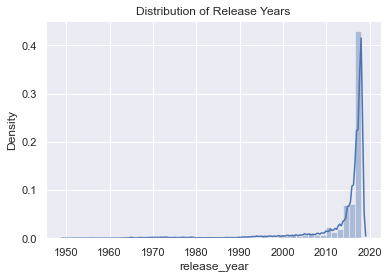

In [22]:
sns.distplot(df_cd.release_year)
plt.title("Distribution of Release Years");

In [23]:
df_cd['mode'].value_counts()

major    7287004
minor    4506440
Name: mode, dtype: int64

In [24]:
df_cd['mode'].value_counts() / df_cd['mode'].count()

major    0.617886
minor    0.382114
Name: mode, dtype: float64

In [25]:
df_cd['mode'] = (df_cd['mode'] == 'major').astype('int32')

In [26]:
tf = df_cd.time_signature.value_counts().sort_index()
tf / tf.sum()

0    0.000416
1    0.006727
3    0.050975
4    0.926476
5    0.015406
Name: time_signature, dtype: float64

In [27]:
df_cd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11793444 entries, 0 to 11793443
Data columns (total 41 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   session_id                     object 
 1   session_position               int64  
 2   track_id                       object 
 3   context_switch                 int64  
 4   no_pause_before_play           int64  
 5   short_pause_before_play        int64  
 6   long_pause_before_play         int64  
 7   hist_user_behavior_n_seekfwd   int64  
 8   hist_user_behavior_n_seekback  int64  
 9   hist_user_behavior_is_shuffle  int32  
 10  premium                        int32  
 11  skipped                        int32  
 12  duration                       float64
 13  release_year                   int64  
 14  us_popularity_estimate         float64
 15  acousticness                   float64
 16  beat_strength                  float64
 17  bounciness                     float64
 18  

In [28]:
import pickle
#df_cd.to_pickle("new data/full_dataset.pkl")
full_data = pd.read_pickle("new data/full_dataset.pkl")

In [29]:
full_data = full_data.drop(columns=['session_position'])

In [30]:
full_data.head()

,session_id,track_id,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,t_46c04497-7db9-461f-a78b-be47de38e659,0,0,0,0,0,0,1,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
1,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,1,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
2,62_03d8ebcd-e5e1-41a0-966b-258d296d8af7,t_46c04497-7db9-461f-a78b-be47de38e659,0,0,1,1,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
3,62_04d0781a-278f-48ce-b5d7-ceaeb37f3dd0,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
4,62_04d0781a-278f-48ce-b5d7-ceaeb37f3dd0,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704


In [31]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11793444 entries, 0 to 11793443
Data columns (total 40 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   session_id                     object 
 1   track_id                       object 
 2   context_switch                 int64  
 3   no_pause_before_play           int64  
 4   short_pause_before_play        int64  
 5   long_pause_before_play         int64  
 6   hist_user_behavior_n_seekfwd   int64  
 7   hist_user_behavior_n_seekback  int64  
 8   hist_user_behavior_is_shuffle  int32  
 9   premium                        int32  
 10  skipped                        int32  
 11  duration                       float64
 12  release_year                   int64  
 13  us_popularity_estimate         float64
 14  acousticness                   float64
 15  beat_strength                  float64
 16  bounciness                     float64
 17  danceability                   float64
 18  